<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/18_Transformer_recipe_generator_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.6 MB/s eta 0:00:00


In [2]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.9 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
vocab_size = AutoConfig.from_pretrained(model_ckpt).vocab_size

In [4]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import pickle
from googletrans import Translator

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
transformer_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator')
attention_scores_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores')

In [7]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_recipe(dish, temp=0.1, lang='en'):
    prompt = 'Recipe for {}'.format(dish)
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

In [8]:
gen_recipe('chicken', temp=0.1, lang='ja')

........................................................................................


('recipe for chicken and dumplings : in a large bowl, combine the chicken, milk, eggs, milk, milk, and salt. mix well. add the flour, and mix well. heat the oil in a large skillet over medium heat. add the chicken, and cook until golden brown on both sides, about 5 minutes. stir in the chicken broth, and cook until the chicken is no longer pink in the center, about 5 minutes.',
 '鶏肉とdump子のレシピ：大きなボウルに、鶏肉、牛乳、卵、牛乳、牛乳、塩を混ぜます。よく混ぜます。小麦粉を加え、よく混ぜます。大きなフライパンでオイルを中火で加熱します。鶏肉を加え、両側に金色の茶色になるまで、約5分間調理します。チキンスープをかき混ぜ、鶏肉が中央でピンク色になるまで約5分間調理します。')

In [9]:
gen_recipe('chicken', temp=1.2, lang='ja')

....................................................................................................
...................................................................


('recipe for chicken breasts : mix the garlic powder, spanish : in a small bowl. stir vegetable soup mix in chicken broth and chili powder. simmer for 20 minutes. before serving. sprinkle butter into the water until pastry is very thickened, 30 to 45 minutes. season with salt and pepper. heat peanut butter in a large saucepan over medium heat. beat in ricotta cheese, sesame oil, sugar, pepper and fennel in a large saucepan over medium heat. stir in the mushrooms and cook until tender. mix in the flour mixture, milk, skin - side down with your hands, melts. slowly whisk in again. add remaining five tablespoons chicken broth mixture just enough to coat. test the thicker filling in ice water for sticky. serve garnish with fresh parsley to serve.',
 '鶏の胸肉のレシピ：ニンニクの粉を混ぜ、スペイン語：小さなボウルに入れます。チキンスープとチリパウダーの野菜スープミックスをかき混ぜます。20分間煮る。サーブする前に。ペストリーが非常に濃くなるまで30〜45分間バターを水に振りかけます。塩とコショウで味付けします。中火で大きな鍋にピーナッツバターを加熱します。リコッタチーズ、ごま油、砂糖、コショウ、フェンネルを中火で大きな鍋に叩きます。キノコをかき混ぜ、柔らかくなるまで調理します。小麦粉の混合物、牛乳、皮膚を混ぜ合わせます - 手で

In [10]:
gen_recipe('apple', temp=0.1, lang='ja')

....................................................................................................
....


('recipe for apple - crusted chicken : preheat oven to 400 degrees f ( 200 degrees c ). grease a 9x13 - inch baking dish. bring a large pot of lightly salted water to a boil. add pasta and cook until tender, about 5 minutes. drain. in a large bowl, combine the chicken, chicken, onion, and garlic. mix well. pour over chicken and toss to coat. bake in the preheated oven until chicken is no longer pink in the center, about 30 minutes.',
 'リンゴのレシピ - クラストチキン：オーブンを400度F（200度C）に予熱します。9x13 -インチベーキング皿にグリースを塗ります。軽く塩水の大きな鍋を沸騰させます。パスタを加え、柔らかくなるまで約5分間調理します。ドレイン。大きなボウルに、鶏肉、鶏肉、玉ねぎ、ニンニクを混ぜます。よく混ぜます。鶏肉とトスを注ぎ、コーティングします。鶏肉が中央でピンク色にならなくなるまで、約30分間、予熱したオーブンで焼きます。')

In [11]:
gen_recipe('apple', temp=1.2, lang='ja')

....................................................................................................
.........................................................................................


('recipe for apple baked apple - crumbleciers : preheat oven to 200 degrees f ( 95 degrees c ). lightly grease three shallow 8 - inch square baking pan or line with cooking spray. whisk the reserved cooking spray. in a large heavy saucepan over medium heat. gradually whisk flour, sugar, allspice, curry powder, and salt into the cooled quinoa ; gradually stir until incorporated, like a raggedy / crust has caramelizedened, beat the brown sugar, eggs, oil, with an electric mixer in a large bowl ; stir into far stream on low speed ; beat on low until it has incorporated and moistened ; beat in 1 cup sour cream. refrigerate constantly until lumps remain. reduce heat to low, and continue to bake an additional 30 to 35 minutes, or until set and cooled, stirring occasionally. cover bowl with waxed paper and wrap in plastic wrap.',
 'Apple焼きリンゴのレシピ-Crumbleciers：オーブンを200度F（95度C）に予熱します。3つの浅い8 -インチの正方形のベーキングパンまたは調理用スプレーを軽く塗ります。予約された調理用スプレーを泡立てます。中火で大きな重い鍋で。徐々に小麦粉、砂糖、オールスパイス、カレーパウダー、塩を冷却したキノアに泡立てます

In [12]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

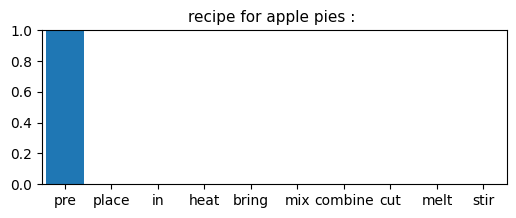

In [13]:
top_k('recipe for apple pies : ', temp=0.1)

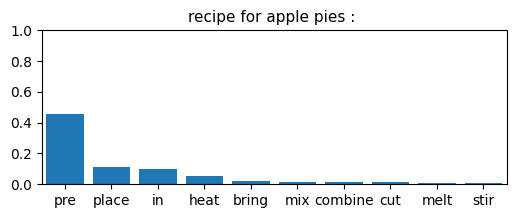

In [14]:
top_k('recipe for apple pies : ', temp=1.2)

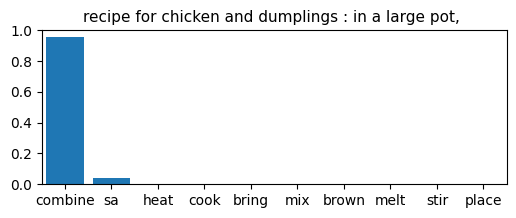

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)

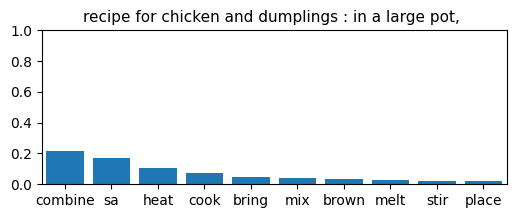

In [16]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.2)

In [17]:
prompts = [
    'recipe for chicken steak : in a large bowl, combine the chicken, onion,',
    'recipe for chicken breasts : mix the garlic powder in a small bowl.',
    'in a small bowl. stir vegetable soup and mix in chicken',
]

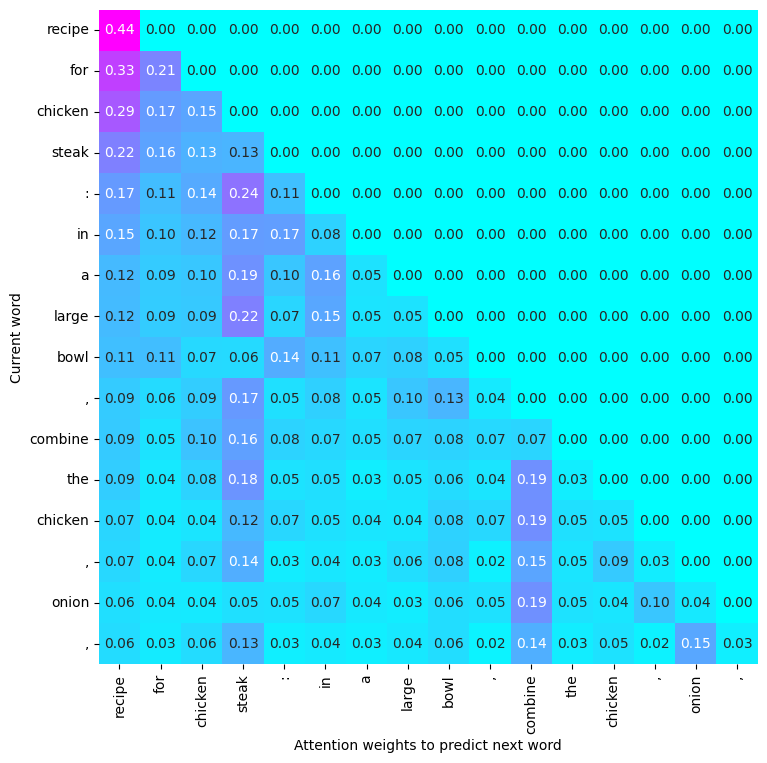

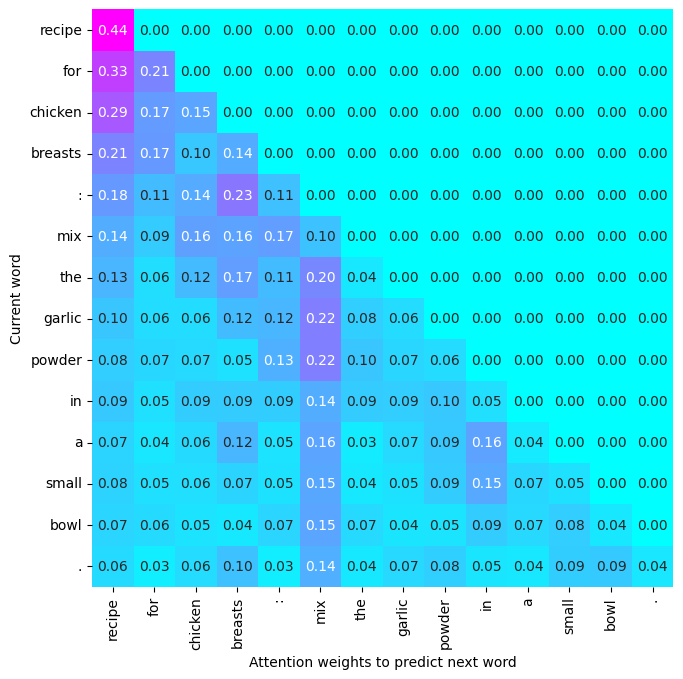

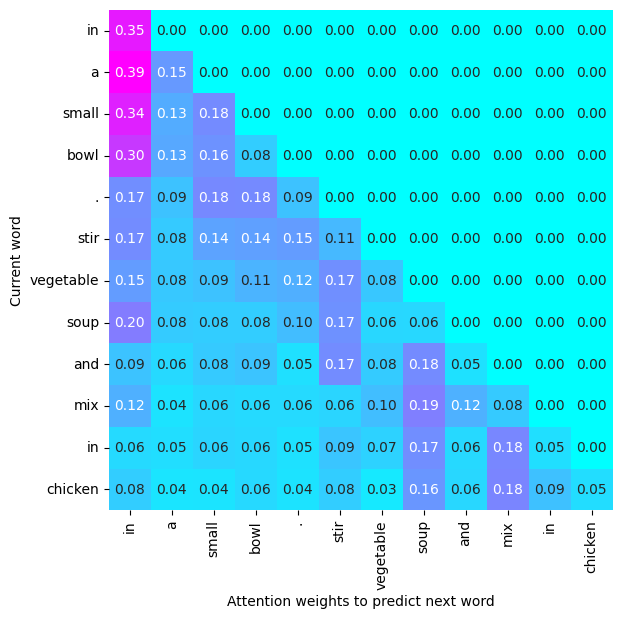

In [18]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(np.mean(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[1:text_len], yticklabels=labels[1:text_len],
                    cmap='cool', cbar=False, annot=True, fmt='1.2f')
    _ = heatmap.set(xlabel='Attention weights to predict next word', ylabel='Current word')